# Chapter 1

## Create a DataJoint Pipeline and write an NWB file

This notebook models the use of Jupyter as a lab notebook. It walks through the steps of creating a DataJoint pipeline and writing an NWB file. Creating a copy of this notebook and updating it each time a session is run is the fastest way to implement NWB and DataJoint.

Metadata describing the mouse and experimental session stored in variables of the second and third cells.  Storing data in Jupyter is not considered a best practice in computer science; however, because we also save those variables in an NWB file and also in a database, it is sufficient for evaluation purposes.  

The coordinate data representing the position of a mouse is stored in CSV files in a standard file tree, grouped by mouse number, with subdirectories for each session

## Section 1: Import libraries and define variables

We begin by importing libraries:

In [1]:
import numpy as np
import os
import pynwb #NWB API
import pandas as pd
import h5py #Provides methods to supplement NWB
import datajoint as dj #
import csv 
from datetime import datetime
from dateutil import tz
from pynwb import NWBHDF5IO
from matplotlib import pylab as plt
#import import_ipynb #Import modules from other notebooks

Variables are used to store information.  We use variables to identify the experimental subject and the session.

In [2]:
#These variables will need to be updated every session
subject_id = 'Mouse_5025'
session_id = 'Session_22'

Path variables are used to navigate the directory structure.  'Experiment_path' is used to specify the root directory of the file structure and should be replaced with the path on your local system. It is used to construct the path to the data_directory where a CSV containing coordinates of a mouse's position is stored.

In [3]:
#Note: The '/' is not universal between operating systems and may need to be replaced with '\'
experiment_path = 'C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1' #Your path here

data_directory = experiment_path + '/' + subject_id + "/" + session_id + "/"

#Navigate to data directory
os.chdir(data_directory)

#We use a string to represent the location of a video containing raw data. (Actual video was omitted for simplicity)
raw_data_link = experiment_path + '/' + subject_id + '/' + session_id + '/raw_video.avi' 

To reach the goal of self documenting files, NWB specfies high level information about the lab, experiment, as well as the timeseries and the subject.

In [4]:
#These variables can be updated as needed

#NWB File Meta Data, update as needed
session_description = 'Determine if mouse has a place preference'
experimenter = 'Experimenter 1'
institution='Yale University'
lab = 'Tan lab'
experiment_description = 'Demonstrate creating a single NWB file and loading a DataJoint pipeline from an experimental session'

#Capture the starting time of your session.
session_start_time = datetime.now()

#Timeseries Meta Data
reference_frame = 'Zero refers to the bottom left corner of the rig, when viewed from above'
rate = 30.0
comments = 'Will need to correct camera jitter'
description = 'The position of a mouse in an arena is transformed into X,Y coordinates'
starting_time = 0.0 #Our timer starts at zero

#Mouse Meta Data
subject_description = 'Fuzzy'
genotype = 'B6'
sex = 'F'
species = 'Mus musculus'
weight = '25g'
date_of_birth = datetime(2017, 4, 3, 11, tzinfo=tz.tzlocal())

#The PyNWB module has optional fields that are very useful, but ommitted here for simplicity.  These include
#protocol number, key words, and publications.  Check out the complete list here:
#https://pynwb.readthedocs.io/en/stable/pynwb.file.html

These variables construct unique IDs from metadata and do not need to be updated

In [5]:

identifier = subject_id + "_" + session_id #This uniquely identifies a file
name = session_id #This links the timeseries with the session number timeseries
nwbfile_name = identifier + '.nwb' #The file identifier references the subject and the session

## Section 2: Connect to DataJoint and create pipeline

Now that we have data we will connect to DataJoint's tutorial server. You will need to obtain credentials for the DataJoint tutorial server here: https://datajoint.io/

We want to do this more than once, so we will define a functionto do that makes our variables accessible to other notebooks.

In [6]:
def connect_to_dj():
    dj.config['database.host'] = 'tutorial-db.datajoint.io' #Tutorial server
    dj.config['database.user'] = '<username>'
    dj.config['database.password'] = '<password>'

    dj.conn()

    #Create a schema to organize the pipeline. Defining it here means you only need to change the code in one place.
    current_schema = dj.schema('<username>_tutorial', locals())
    return current_schema

Execute the connect_to_dj function and store 'current_schema' in the variable, 'schema'.

In [7]:
schema = connect_to_dj()
schema

Connecting marikelreimer@tutorial-db.datajoint.io:3306


Schema `marikelreimer_tutorial`

We will define tables, one by one, using ERD.draw() to visualize the growing pipeline. Our first table is designed to store data about experimental mice. It a manual table, indicated by (dj.Manual) which means data can be directly inserted into it.   Subject_id is the primary key for this table, which is denoted by it being above the '---'.  The fields below that line represent columns in the table and are followed by their data type e.g varchar,enum, and timestamp(128).  We refer readers to https://tutorials.datajoint.io/ which provides thorough documentations in Matlab and python.

In [8]:
#Define Mouse table
@schema
class Mouse(dj.Manual):
    definition = """
    subject_id: varchar(128)                  # Primary keys above the '---'
    ---
    #non-primary columns below the '---' in alphabetical order
    date_of_birth: timestamp 
    genotype: enum('B6', 'BalbC')    
    sex: enum('M', 'F', 'U')
    species: varchar(128)
    subject_description: varchar(128)
    weight: varchar(128)
    """

We instantiate the 'Mouse' class and store it in the variable, 'mouse' which is a DataJoint best practice.

In [9]:
#Uppercase characters refer to tables, lowercase to variables
mouse = Mouse() 

In naming the field 'subject_description' we made a deviation from the NWB naming convention, which is simply 'description'. The reason for this choice is that DataJoint  will give an error if you try to join two tables with the same column name.

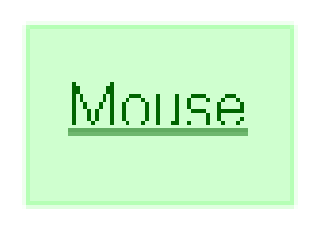

In [10]:
dj.ERD(schema).draw()

Next we define a table to store session data.  This table has a dependency on the Mouse table, which is indicated with the -> symbol.  This table's primary key is Session_id and each row in our our dataset can be uniquely identified with subject_id and session_id.

In [11]:
#Define session table

@schema
class Session(dj.Manual):
        definition = """
        ->Mouse                                  #Dependency on Mouse table established
        name: varchar(128)                  #Primary key for the session table
        ---
        comments: varchar(128)
        description: varchar(128) #Timeseries description
        experiment_description: varchar(128)
        experimenter: enum('Experimenter 1', 'Experimenter 2')
        identifier: varchar(128)                
        institution: varchar(128)
        lab: varchar(128)
        rate: float
        raw_data_link: varchar(128)
        reference_frame: varchar(128)
        session_description: varchar(128)
        session_start_time: timestamp
        starting_time: float
        """

We instantiate the 'Session' class and store it in the variable, 'session'

In [12]:
session = Session()
session

subject_id Primary keys above the '---',name Primary key for the session table,comments,description Timeseries description,experiment_description,experimenter,identifier,institution,lab,rate,raw_data_link,reference_frame,session_description,session_start_time,starting_time


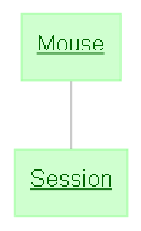

In [13]:
dj.ERD(schema).draw()

The Position table inherits from the Session table.  It is an imported table, indicated by (dj.Imported) and it imports coordinates data from a csv file in from the specified data directory.  The coordinate data is stored as an array using the longblob data type.  We can load data from a variety of source file types, so we will plan ahead, specifying a file type, which is extended in Chapter 3.  When adapting this framework, replace line 13 with your methoods for reading data.

In [14]:
source_data = 'NoseLocationLog.csv'

In [15]:
@schema
class Position(dj.Imported):
    definition = """
    -> Session
    ---
    coordinates:  longblob    # X,Y coordinates of mouse
    """
    #make tuples function takes data from parent tables and inserts values into itself. 
    def _make_tuples(self, key):
        if source_data == 'NoseLocationLog.csv':

            #Use numpy to read csv
            data = np.genfromtxt('NoseLocationLog.csv', delimiter=',', skip_header=1)

            #Store data in coordinates key
            key['coordinates'] = data

            #Insert key into table
            self.insert1(key)

            print('Populated a position for {subject_id}'.format(**key))
        
        #Alert users to errors
        else:
            print('Unknown source file')

We instantiate the 'Position' class and store it in the variable, 'position'.  

In [16]:
position = Position
position

__main__.Position

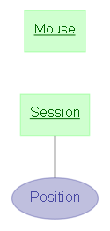

In [17]:
dj.ERD(schema).draw()

Position_Statistics is our final table and is an example of a computed table, indicated by (dj.Computed). We calculated the amount of time a mouse spent in each half of an arena and used it to create a preference index. Columns are defined to store the results of the calculations, ensuring that data and analytis products are always linked. The code in the make_tuples method counts the coordinates representing the time the mouse spent in the left or right half of the arena and uses these values to calculate a preference index. This code is specific to this project, but can be replaced by other numpy analysis methods.

In [18]:
@schema
class PositionStatistics(dj.Computed):
    definition = """
    -> Position
    ---
    left_side: float    #count of coordinates in left half of arena
    right_side: float    #count of coordinates in the right half of arena
    preference_index: float #left_side - right_side/ left_side + right_side 
    """
    
    def _make_tuples(self, key):
        print('Populating for: ', key)
        

        coordinates = (Position() & key).fetch1('coordinates')    # fetch activity as NumPy array
        coordinates = coordinates[:,0] #We use only the X values, since we are comparing time spent in the left versus right half of the arena
        
        arena_length = max(coordinates) #Find the length of the arena

        #Store counts of the number of coordinates on the left side of the arena 
        left_side = (coordinates < (arena_length/2)).astype(np.int)
        #Store counts of the number of coordinates on the right side of the arena 
        right_side = (coordinates > (arena_length/2)).astype(np.int)

        #Calculate a preference index using the sum of the coordinate counts
        preference_index = (left_side.sum() - right_side.sum())/(left_side.sum() + right_side.sum())

        #Count the values stored in the varialbes results and insert
        key['left_side'] = left_side.sum()
        key['right_side'] = right_side.sum()
        key['preference_index'] = preference_index
        self.insert1(key)

We instantiate the 'PositionStatistics' class and store it in the variable, 'positionStatistics'

In [19]:
positionStatistics = PositionStatistics()

positionStatistics

subject_id Primary keys above the '---',name Primary key for the session table,left_side count of coordinates in left half of arena,right_side count of coordinates in the right half of arena,preference_index left_side - right_side/ left_side + right_side


Here is our completed pipeline

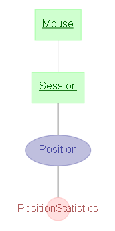

In [20]:
dj.ERD(schema).draw()

## Section 4: Load DataJoint Pipeline

The pipeline is complete and we load data into tables in the order they were created.  Mouse is a manual table, so we use can use DataJoint's insert1 function to pass data to it. When we insert data into the pipeline, we must be careful to keep our variables in the same order as the table definition.  DataJoint validates on type of data, however, it does not check to see if your variables match your column names.  This means that validation is needed because you could, for example, insert the lab's name into the file identifier without raising an error.

In [21]:
mouse.insert1((
    subject_id, 
    date_of_birth,
    genotype,
    sex,   
    species,
    subject_description,
    weight
    ))  

To promote interoperable code, we are following the convention of listing non-primary keys in alphabetical order. When you are setting up, it is good to review each table after loading it to verify that data ended in the correct column.  

In [22]:
mouse

subject_id Primary keys above the '---',date_of_birth,genotype,sex,species,subject_description,weight
Mouse_5025,2017-04-03 11:00:00,B6,F,Mus musculus,Fuzzy,25g


Next we insert session data:

In [23]:
Session.insert1((
    subject_id, #Primary key for mouse table
    name, #Primary key for session table
    comments, 
    description,
    experiment_description,
    experimenter,
    identifier,
    institution, 
    lab, 
    rate,
    raw_data_link,
    reference_frame,
    session_description,
    session_start_time,
    starting_time
    ))

Verify that the columns display the correct data:

In [24]:
session

subject_id Primary keys above the '---',name Primary key for the session table,comments,description Timeseries description,experiment_description,experimenter,identifier,institution,lab,rate,raw_data_link,reference_frame,session_description,session_start_time,starting_time
Mouse_5025,Session_22,Will need to correct camera jitter,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate creating a single NWB file and loading a DataJoint pipeline from an experimental session,Experimenter 1,Mouse_5025_Session_22,Yale University,Tan lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5025/Session_22/raw_video.avi,"Zero refers to the bottom left corner of the rig, when viewed from above",Determine if mouse has a place preference,2020-07-07 15:36:13,0.0


Because Position is an imported table, we use the populate method instead of an insert method:

In [25]:
position.populate()

Populated a position for Mouse_5025


PositionStatistics is a computed table, which also uses a populate method:

In [26]:
positionStatistics.populate()   

Populating for:  {'subject_id': 'Mouse_5025', 'name': 'Session_22'}


We use * to join our tables and now have one row representing one complete entry in our data set.  

In [27]:
mouse * session * position * positionStatistics 

subject_id Primary keys above the '---',name Primary key for the session table,date_of_birth,genotype,sex,species,subject_description,weight,comments,description Timeseries description,experiment_description,experimenter,identifier,institution,lab,rate,raw_data_link,reference_frame,session_description,session_start_time,starting_time,"coordinates X,Y coordinates of mouse",left_side count of coordinates in left half of arena,right_side count of coordinates in the right half of arena,preference_index left_side - right_side/ left_side + right_side
Mouse_5025,Session_22,2017-04-03 11:00:00,B6,F,Mus musculus,Fuzzy,25g,Will need to correct camera jitter,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate creating a single NWB file and loading a DataJoint pipeline from an experimental session,Experimenter 1,Mouse_5025_Session_22,Yale University,Tan lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5025/Session_22/raw_video.avi,"Zero refers to the bottom left corner of the rig, when viewed from above",Determine if mouse has a place preference,2020-07-07 15:36:13,0.0,=BLOB=,9856.0,7912.0,0.10941


## Section 5: Create NWB file

Methods from the pynwb library streamline writing data to NWB files.  PyNWB's subject class is a container that is used to write our metadata to the appropriate location in the NWB file.

In [28]:
#Load subject data
subject = pynwb.file.Subject(
    description = subject_description,
    genotype = genotype,
    sex = sex,
    species = species,
    subject_id = subject_id,
    weight = weight,
    date_of_birth = date_of_birth
    )

The NWBFile container is used to pass high level data and the subject data to an NWB file.  

Working with timezones in datetime data can be difficult, but necessary for team members working in mulitple locations. The pynwb API checks datetime fields, such as session_start_time to see if the timezone is present, and generates it if it is missing.

In [29]:
#Create NWB file structure and high level data
nwbfile = pynwb.file.NWBFile(
    session_description, #Session description
    identifier, #file identifier
    session_start_time, 
    experimenter = experimenter,
    lab = lab,
    institution = institution,
    experiment_description = experiment_description,
    subject = subject
    )

C:\Users\meowm\AppData\Local\Continuum\anaconda3\lib\site-packages\pynwb\file.py:749: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


Next we create an image series containing a mock link to raw data, which is added to the Acquisition group.

In [30]:
#Add link to raw data in the acquisition group

raw_data = pynwb.image.ImageSeries(
    'Raw Data',
    format = 'external',
    rate = rate, #Unit is Hz
    external_file = [raw_data_link],
    starting_frame = [0]
    )

nwbfile.add_acquisition(raw_data)

We retrieve our coordinate data from DataJoint and pass it to a SpatialTimeseries. Next we create a Processing module called 'behavior' in the NWB file, and then add the SpatialTimeseries to it.

In [31]:
#This code retrieves data, passes it to the SpatialSeries NWB container, and stores it in the Processing group in the NWB file

#We retrieve the coordinate data from DataJoint
data = position.fetch1('coordinates')
data = data[:]

#Create an NWB timeseries and pass data to it
spatial_timeseries = pynwb.behavior.SpatialSeries(
    name, 
    data, 
    reference_frame = reference_frame,
    starting_time = starting_time,
    rate = rate, #Unit is Hz
    comments = comments, 
    description = description
    )

#Create a module in the Processing group called 'behavior' 
behavior_module = nwbfile.create_processing_module('behavior', 'Spatial series containing coordinates representating the location of a mouse')

#Add the spatial timeseries to the behavior module
nwbfile.processing['behavior'].add(spatial_timeseries)

Session_22 pynwb.behavior.SpatialSeries at 0x1654178944648
Fields:
  comments: Will need to correct camera jitter
  conversion: 1.0
  data: [[ 90.  72.]
 [ 91.  67.]
 [ 89.  70.]
 ...
 [316. 192.]
 [314. 194.]
 [312. 195.]]
  description: The position of a mouse in an arena is transformed into X,Y coordinates
  rate: 30.0
  reference_frame: Zero refers to the bottom left corner of the rig, when viewed from above
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: meters

In [32]:
#Write the NWB file we use the NWBHDF5IO class, which maps data to the hdf5 file. 'W' or write mode
#We use the with command, which closes the file at the end of the cell.
with NWBHDF5IO(nwbfile_name, 'w') as io:
     io.write(nwbfile)

Finally we retrieve the preference index from the position statistics table and save it in the analysis group. Due to the diversity of analysis, NWB did not provide methods for populating that group, so native Hdf5 methods may be used. We illustrate this by using the h5py.File with append option, indicated by 'a'. The h5py function is very similiar to the NWBHDF5IO used above, although it does not provide the same degree of validation.

In [33]:
#Retrieve prerence index from the PositionStatistics table
preference_index = positionStatistics.fetch1('preference_index')

#Open our file and append the preference_index to a dataset in the analysis group
with h5py.File(nwbfile_name, 'a') as f:
    #Specify the analysis group in our file
    d = f['analysis']
    #Use hdf5 method to create and populate a dataset
    d.create_dataset("preference_index", data = preference_index)

In Jupyter, the '!' symbol lets us access some commands from the command line interface.  This lets us validate our files to ensure that they have been created correctly. Note that because it mimics a command line interface, this function can't access the name stored in the nwbfile_name variable.

In [34]:
! python -m pynwb.validate Mouse_5025_Session_22.nwb

Validating Mouse_5025_Session_22.nwb against cached namespace information using namespace core.
 - no errors found.


## Quick Start: If you are using Jupyter as a virtual lab notebook and have several sessions in the pipeline, you may append the queries used in Chapter 3 here.

## Before proceeding to the next chapter update DataJoint credentials in ImportsAndTableDefinitions.py.

It is a best practice to keep classes and functions that you use repeatedly in a single file, so updating code can be done in a single place.  